# Alternatieve Toets TDY2
Calculationsheet for a gasturbine  

_note_: The cell below is needed to import libraries and set global settings.

In [1]:
%matplotlib notebook
%precision 3
from IPython.display import Latex
from math import nan
import matplotlib.pyplot as plt
from GasTurbine import *

# Decription of the system
## States
The following states are identified:  
0. Air at atmospheric conditions $ P_0 = P_{atm} $, $ T_0 = T_{atm} $ and $ v_0 = v_{atm} $
1. Compressed air $ P_1 >> P_0 $, $ T_1 > T_0 $ and $ v_1 << v_0 $
2. Heated air $ P_2 = P_1 $, $ T_2 >> T_1 $ and $ v_2 > v_1 $
3. Heated air at atmospheric pressure $ P_3 = P_0 = P_{atm} $, $ T_3 < T_2 $

## Transitions
The system transitions are identified as follows:  
0 -> 1 **Isentropic compression** were air is sucked into a compressor.  
1 -> 2 **Isobaric heating** where air is heated in a combustion chamber.  
2 -> 3 **Isentropic expansion** where air is expanded till atmospheric pressure.  
3 -> 0 **Isobaric cooling** A fictive step where the air is cooled to atmorspheric conditions.  

# Know values

In [2]:
P_atm = 1.013 * u.bar
T_atm = (15. * u.degC).to(u.K)
c = Cycle()
c.c_p = 1005. * u.J / (u.kg * u.K)
c.c_v = 716. * u.J / (u.kg * u.K)
c.Q_in = 2000 * u.kW

In [3]:
s = States(4)
s[0].P = P_atm
s[0].T = T_atm
s[0].A = 1. * u.m ** 2
s[0].V_flux = 6000. * u.m ** 3 / u.hr
s[1].P = 10. * u.bar
s[1].A = 0.5 * u.m ** 2
s[2].A = 0.1 * u.m ** 2
s[2].P = s[1].P
s[3].A = 1. * u.m ** 2
s[3].P = s[0].P

In [4]:
c.t = s
c.t[0].processtype = ProcessType.ISENTROPIC
c.t[1].processtype = ProcessType.ISOBARIC
c.t[2].processtype = ProcessType.ISENTROPIC
c.t[3].processtype = ProcessType.ISOBARIC

# Calculate of system constants
\begin{equation}
    \frac{P_0 \dot{V_0}}{T_0} = \dot{m} R \rightarrow \dot{m} = \frac{P_0 \dot{V_0}}{R T_0}
\end{equation}
\begin{equation}
    R = c_p - c_v
\end{equation}
\begin{equation}
    k = \frac{c_p}{c_p}
\end{equation}

In [5]:
latex(c.R)

<IPython.core.display.Latex object>

In [6]:
latex(c.k)

<IPython.core.display.Latex object>

In [7]:
def mass_flux(P, V_flux, R, T):             
    return (P * V_flux / (R * T)).to('kg/s')

c.m_flux = mass_flux(s[0].P, s[0].V_flux, c.R, s[0].T)
latex(c.m_flux)

<IPython.core.display.Latex object>

# Calculate Transitions and States
## State 0
\begin{equation}
    \rho_0 = \frac{P_0}{T_0 R}
    \begin{cases}
        \frac{P_0 v_0}{T_0} = \dot{m} R \\
        \rho_0 = \frac{\dot{m}}{v_0}
    \end{cases}
\end{equation}
\begin{equation}
    v_0 = \frac{\dot{V_0}}{\dot{m}}
\end{equation}
\begin{equation}
    c_0 A_0 \rho_0 = \dot{m} \rightarrow c_0 = \frac{\dot{m}}{\rho_0 A_0}
\end{equation}


In [8]:
def density(P, R, T):   
    return P / (R * T)


def specific_volume(m_flux, V_flux):
    return V_flux / m_flux


def speed(m_flux, rho, A):
    return m_flux / (rho * A)

In [9]:
s[0].rho = density(s[0].P, c.R, s[0].T)
s[0].v = specific_volume(c.m_flux, s[0].V_flux)
s[0].c = speed(c.m_flux, s[0].rho, s[0].A)
s[0].print()

,value
$ P_{0} $,$ 101300.0000\ \mathrm{Pa} $
$ T_{0} $,$ 288.1500\ \mathrm{K} $
$ v_{0} $,$ 0.8221\ \frac{\mathrm{m}^{3}}{\mathrm{kg}} $
$ \dot{V}_{0} $,$ 1.6667\ \frac{\mathrm{m}^{3}}{\mathrm{s}} $
$ \rho_{0} $,$ 1.2164\ \frac{\mathrm{kg}}{\mathrm{m}^{3}} $
$ c_{0} $,$ 1.6667\ \frac{\mathrm{m}}{\mathrm{s}} $


## State 1
Where $ \rho_1 $, $ c_1 $ and $ v_1 $ are determined with the previous given formula.
\begin{equation}
    \frac{T_0^k}{P_0^{k-1}} = \frac{T_1^k}{P_1^{k-1}} \rightarrow T_1 = \left(\left(\frac{P_1}{P_0}\right)^{k-1}T_0^k\right)^{\frac{1}{k}}
\end{equation}
\begin{equation}
    \dot{V}_1 = c_1 A_1
\end{equation}

In [10]:
@u.wraps(ret='K', args=('K', 'Pa', 'Pa', ''))
def isentropische_dT(T_s, P_s, P_e, k):
    return ((P_e / P_s) ** (k - 1) * T_s ** k) ** (1 / k)


def V_flux(c, A):
    return c * A

In [11]:
s[1].T = isentropische_dT(s[0].T, s[0].P, s[1].P, c.k)
s[1].rho = density(s[1].P, c.R, s[1].T)
s[1].c = speed(c.m_flux, s[1].rho, s[1].A)
s[1].V_flux = V_flux(s[1].c, s[1].A)
s[1].v = specific_volume(c.m_flux, s[1].V_flux)
s[1].print()

,value
$ P_{1} $,$ 1000000.0000\ \mathrm{Pa} $
$ T_{1} $,$ 556.6315\ \mathrm{K} $
$ v_{1} $,$ 0.1609\ \frac{\mathrm{m}^{3}}{\mathrm{kg}} $
$ \dot{V}_{1} $,$ 0.3261\ \frac{\mathrm{m}^{3}}{\mathrm{s}} $
$ \rho_{1} $,$ 6.2163\ \frac{\mathrm{kg}}{\mathrm{m}^{3}} $
$ c_{1} $,$ 0.6523\ \frac{\mathrm{m}}{\mathrm{s}} $


## Transition 0 to 1
The transition from **state 0** to **state 1** is an isentropic process where work needs to be put into the system and no heat is transfered.
\begin{equation}
    w_{0-1} = \frac{-1}{k-1}\left(P_1 v_1 - P_0 v_0\right)
\end{equation}
\begin{equation}
    q_{0-1} = 0.
\end{equation}
\begin{equation}
    \Delta u = q_{0-1} - w_{0-1}
\end{equation}
\begin{equation}
    w_{t,0-1} = q_{0-1} - \Delta h - \Delta e_{kin} - \Delta e_{pot}
\end{equation}
\begin{equation}
    \Delta e_{kin} = \frac{1}{2}(c_1^2 - c_0^2)
\end{equation}
\begin{equation}
    \Delta h_{0-1} = q_{0-1} - w_{t,0-1} - \Delta e_{kin}
\end{equation}

In [12]:
def isentropisch_work(P_s, V_s, P_e, V_e, k):
    return -1. / (k - 1) * (P_e * V_e - P_s * V_s)


def delta_u(q, w):
    return q - w


def delta_e_kin(c_s, c_e):
    return 0.5 * (c_e ** 2 - c_s ** 2)


def delta_h(T_s, T_e, c_p):
    return c_p * (T_e - T_s)


def technical_work(q, dh, de_kin, de_pot):
    return q - dh - de_kin - de_pot

In [13]:
c.t[0].q = 0. * u.kJ / u.kg
c.t[0].w = isentropisch_work(s[0].P, s[0].v, s[1].P, s[1].v, c.k)
c.t[0].du = delta_u(c.t[0].q, c.t[0].w)
c.t[0].de_kin = delta_e_kin(s[0].c, s[1].c)
c.t[0].dh = delta_h(s[0].T, s[1].T, c.c_p)
c.t[0].w_t = technical_work(c.t[0].q, c.t[0].dh, c.t[0].de_kin, c.t[0].de_pot)
c.t[0].print()

,value
$ q_{0->1} $,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ w_{0->1} $,$ -192.2327\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ w_{t,0->1} $",$ -269.8227\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ \Delta u_{0->1} $,$ 192.2327\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ \Delta e_{0->1,kin} $",$ -0.0012\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ \Delta e_{0->1,pot} $",$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ \Delta h_{0->1} $,$ 269.8239\ \frac{\mathrm{kJ}}{\mathrm{kg}} $


## Transition 1 to 2
State 2 can best be calculated by first determining the heat and work transfer in transition 1 -> 2. Since the amount of heating energy $ Q_{in} $ is known. The transition from **state 1** to **state 2** is an isobaric heating process. Where heat is put into the system which is kept at an constant pressure.
\begin{equation}
    q_{1-2} = \frac{Q_{in}}{\dot{m}}
\end{equation}
\begin{equation}
    w_{1-2} = q_{1-2} - \frac{q_{1-2}}{k}
    \begin{cases}
        q_{1-2} = \frac{k}{k-1} P(v_2 - v_1) \\
        w_{1-2} = P(v_2 - v_1)
    \end{cases}
\end{equation}



In [14]:
def isobaar_heat_Qm(Q_in, m_flux):
    return Q_in / m_flux


def isobaar_work_kq(k, q):
    return q - (q / k)

In [15]:
c.t[1].q = isobaar_heat_Qm(c.Q_in, c.m_flux)
c.t[1].w = isobaar_work_kq(k=c.k, q=c.t[1].q)
c.t[1].du = delta_u(c.t[1].q, c.t[1].w)

## State 2
From here **state 2** can be calculated, where $ \rho_2 $, $ v_2 $, $ c_2 $ and $ \dot{V}_2 $ are calculated using earlier provided formulas.
\begin{equation}
    q_{1-2} = c_p(T_2-T_1) \rightarrow T_2 = \frac{q_{1-2}}{c_p} + T_1
\end{equation}

In [16]:
def isobaar_dT(q, c_p, T_s):
    return q / c_p + T_s

In [17]:
s[2].T = isobaar_dT(c.t[1].q, c.c_p, s[1].T)
s[2].rho = density(s[2].P, c.R, s[2].T)
s[2].c = speed(c.m_flux, s[2].rho, s[2].A)
s[2].V_flux = V_flux(s[2].c, s[2].A)
s[2].v = specific_volume(c.m_flux, s[2].V_flux)
s[2].print()

,value
$ P_{2} $,$ 1000000.0000\ \mathrm{Pa} $
$ T_{2} $,$ 1538.2036\ \mathrm{K} $
$ v_{2} $,$ 0.4445\ \frac{\mathrm{m}^{3}}{\mathrm{kg}} $
$ \dot{V}_{2} $,$ 0.9013\ \frac{\mathrm{m}^{3}}{\mathrm{s}} $
$ \rho_{2} $,$ 2.2495\ \frac{\mathrm{kg}}{\mathrm{m}^{3}} $
$ c_{2} $,$ 9.0127\ \frac{\mathrm{m}}{\mathrm{s}} $


## Transition 1 to 2 (continued)
From here the transition can be calculated further, using earlier given formulas.

In [18]:
c.t[1].de_kin = delta_e_kin(s[1].c, s[2].c)
c.t[1].dh = delta_h(s[1].T, s[2].T, c.c_p)
c.t[1].w_t = technical_work(c.t[1].q, c.t[1].dh, c.t[1].de_kin, c.t[1].de_pot)
c.t[1].print()

,value
$ q_{1->2} $,$ 986.4800\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ w_{1->2} $,$ 283.6743\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ w_{t,1->2} $",$ -0.0404\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ \Delta u_{1->2} $,$ 702.8056\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ \Delta e_{1->2,kin} $",$ 0.0404\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ \Delta e_{1->2,pot} $",$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ \Delta h_{1->2} $,$ 986.4800\ \frac{\mathrm{kJ}}{\mathrm{kg}} $


## State 3


In [19]:
s[3].T = isentropische_dT(s[2].T, s[2].P, s[3].P, c.k)
s[3].rho = density(s[3].P, c.R, s[3].T)
s[3].c = speed(c.m_flux, s[3].rho, s[3].A)
s[3].V_flux = V_flux(s[3].c, s[3].A)
s[3].v = specific_volume(c.m_flux, s[3].V_flux)
s[3].print()

,value
$ P_{3} $,$ 101300.0000\ \mathrm{Pa} $
$ T_{3} $,$ 796.2779\ \mathrm{K} $
$ v_{3} $,$ 2.2717\ \frac{\mathrm{m}^{3}}{\mathrm{kg}} $
$ \dot{V}_{3} $,$ 4.6057\ \frac{\mathrm{m}^{3}}{\mathrm{s}} $
$ \rho_{3} $,$ 0.4402\ \frac{\mathrm{kg}}{\mathrm{m}^{3}} $
$ c_{3} $,$ 4.6057\ \frac{\mathrm{m}}{\mathrm{s}} $


## Transition 2 to 3


In [20]:
c.t[2].q = 0. * u.kJ / u.kg
c.t[2].w = isentropisch_work(s[2].P, s[2].v, s[3].P, s[3].v, c.k)
c.t[2].du = delta_u(c.t[2].q, c.t[2].w)
c.t[2].de_kin = delta_e_kin(s[2].c, s[3].c)
c.t[2].dh = delta_h(s[2].T, s[3].T, c.c_p)
c.t[2].w_t = technical_work(c.t[2].q, c.t[2].dh, c.t[2].de_kin, c.t[2].de_pot)
c.t[2].print()

,value
$ q_{2->3} $,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ w_{2->3} $,$ 531.2187\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ w_{t,2->3} $",$ 745.6653\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ \Delta u_{2->3} $,$ -531.2187\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ \Delta e_{2->3,kin} $",$ -0.0300\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ \Delta e_{2->3,pot} $",$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ \Delta h_{2->3} $,$ -745.6352\ \frac{\mathrm{kJ}}{\mathrm{kg}} $


## Transition 3 to 0

In [21]:
c.t[3].q = isobaar_heat(c_p=c.c_p, T_s=s[3].T, T_e=s[0].T)
c.t[3].w = isobaar_work(R=c.R, T_s=s[3].T, T_e=s[0].T)
c.t[3].du = delta_u(c.t[3].q, c.t[3].w)
c.t[3].de_kin = delta_e_kin(s[3].c, s[0].c)
c.t[3].dh = delta_h(s[3].T, s[0].T, c.c_p)
c.t[3].w_t = technical_work(c.t[3].q, c.t[3].dh, c.t[3].de_kin, c.t[3].de_pot)
c.t[3].print()

,value
$ q_{3->0} $,$ -510.6686\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ w_{3->0} $,$ -146.8490\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ w_{t,3->0} $",$ 0.0092\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ \Delta u_{3->0} $,$ -363.8196\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ \Delta e_{3->0,kin} $",$ -0.0092\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
"$ \Delta e_{3->0,pot} $",$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ \Delta h_{3->0} $,$ -510.6686\ \frac{\mathrm{kJ}}{\mathrm{kg}} $


<IPython.core.display.Javascript object>


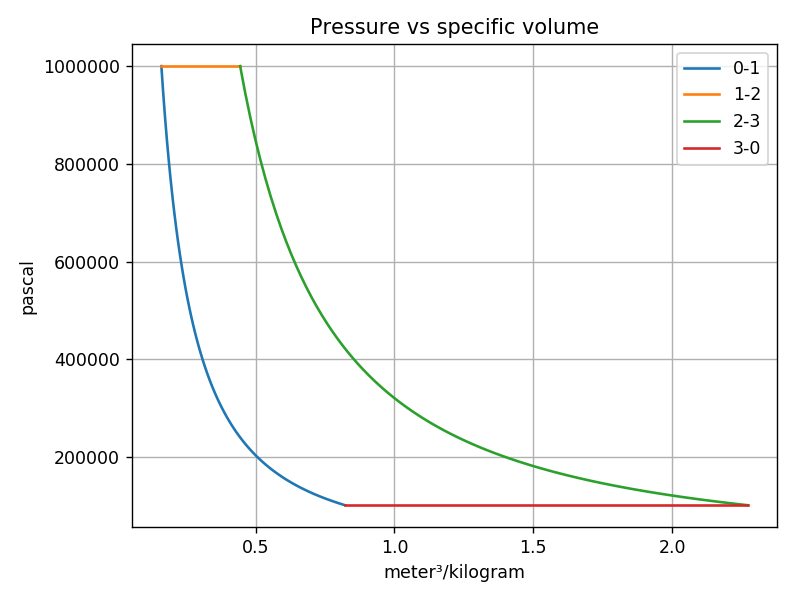

In [22]:
c.plot_Pv()

In [23]:
c.print_closed()

,$ q $,$ \Delta u $,$ w $
0-1,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 192.2327\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -192.2327\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
1-2,$ 986.4800\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 702.8056\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 283.6743\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
2-3,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -531.2187\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 531.2187\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
3-0,$ -510.6686\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -363.8196\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -146.8490\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ \Sigma $,$ 475.8114\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 475.8114\ \frac{\mathrm{kJ}}{\mathrm{kg}} $


In [24]:
c.print_open()

,$ q $,$ \Delta h $,$ w_t $,$ \Delta e_{kin} $,$ \Delta e_{pot} $
0-1,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 269.8239\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -269.8227\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -0.0012\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
1-2,$ 986.4800\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 986.4800\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -0.0404\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 0.0404\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
2-3,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -745.6352\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 745.6653\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -0.0300\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
3-0,$ -510.6686\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -510.6686\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 0.0092\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -0.0092\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
$ \Sigma $,$ 475.8114\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 475.8114\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ -0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $,$ 0.0000\ \frac{\mathrm{kJ}}{\mathrm{kg}} $
